# Continuous-Space Super-Resolution of fODFs in Diffusion MRI

Code by:

Tyler Spears - tas6hh@virginia.edu

Dr. Tom Fletcher

## Imports & Setup

In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import functools
import io
import datetime
import time
import math
import itertools
import os
import shutil
import pathlib
import copy
import pdb
import inspect
import random
import subprocess
import sys
import warnings
from pathlib import Path
import typing
import zipfile
import tempfile

import dotenv

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Data management libraries.
import nibabel as nib
import nibabel.processing
from natsort import natsorted
from pprint import pprint as ppr
from box import Box

# Computation & ML libraries.
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchio
from pytorch_lightning.lite import LightningLite
import monai
import einops
import torchinfo
import skimage

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/work/pitn/.envrc
direnv: creating conda environment

CondaValueError: prefix already exists: /home/tas6hh/miniconda/envs/pitn2


EnvironmentLocationNotFound: Not a conda environment: /



True

In [3]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    # Pick only one device for the default, may use multiple GPUs for training later.
    if "CUDA_PYTORCH_DEVICE_IDX" in os.environ.keys():
        dev_idx = int(os.environ["CUDA_PYTORCH_DEVICE_IDX"])
    else:
        dev_idx = 0
    device = torch.device(f"cuda:{dev_idx}")
    print("CUDA Device IDX ", dev_idx)
    torch.cuda.set_device(device)
    print("CUDA Current Device ", torch.cuda.current_device())
    print("CUDA Device properties: ", torch.cuda.get_device_properties(device))
    # Activate cudnn benchmarking to optimize convolution algorithm speed.
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True
        print("CuDNN convolution optimization enabled.")
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

CUDA Device IDX  0
CUDA Current Device  0
CUDA Device properties:  _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24256MB, multi_processor_count=64)
CuDNN convolution optimization enabled.
cuda:0


In [4]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash
if torch.cuda.is_available():
    # GPU information
    try:
        gpu_info = pitn.utils.system.get_gpu_specs()
        print(gpu_info)
    except NameError:
        print("CUDA Version: ", torch.version.cuda)
else:
    print("CUDA not in use, falling back to CPU")

In [5]:
# cap is defined in an ipython magic command
print(cap)

Author: Tyler Spears

Last updated: 2022-10-26T23:05:19.194431+00:00

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.15.0-48-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: 362384a9b833043dc8c619a8d434c81c1dfc1ae2

torch     : 1.12.1
nibabel   : 4.0.1
seaborn   : 0.11.2
pitn      : 0.0.post1.dev206+gf002231.d20220911
torchio   : 0.18.84
sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]
pandas    : 1.4.3
torchinfo : 1.7.1
json      : 2.0.9
einops    : 0.4.1
matplotlib: 3.5.2
monai     : 1.0.0
numpy     : 1.23.1
skimage   : 0.19.3

==================================================GPU Specs==================================================
  id  Name              Driver Version      CUDA Version  Total Memory    uuid
----  ----------------  ----------------  --------------  --------------  ------

## Experiment & Parameters Setup

In [6]:
p = Box(default_box=True)
# Experiment defaults, can be overridden in a config file.

# General experiment-wide params
###############################################
p.experiment_name = "sr_debug"
p.override_experiment_name = False
p.results_dir = "/data/srv/outputs/pitn/results/runs"
p.tmp_results_dir = "/data/srv/outputs/pitn/results/tmp"
p.train_val_test_split_file = random.choice(
    list(Path("./data_splits").glob("HCP*train-val-test_split*.csv"))
)
p.aim_uri = "aim://dali.cpe.virginia.edu:53800"
###############################################
p.train = dict(
    in_patch_size=(32, 32, 32),
    batch_size=1,
    samples_per_subj_per_epoch=10,
    max_epochs=50,
    loss="mse",
)

# Network/model parameters.
p.encoder = dict(
    interior_channels=75,
    # (number of SH orders (l) + 1) * X that is as close to 100 as possible.
    out_channels=16 * 6,
    n_res_units=3,
    n_dense_units=3,
    activate_fn="elu",
)
p.decoder = dict(
    n_coord_features=3,
    n_context_features=p.encoder.out_channels,
    # n_context_groups=6,
    out_features=45,
    internal_features=126,
    n_layers=5,
    activate_fn="elu",
)

# If a config file exists, override the defaults with those values.
try:
    if "PITN_CONFIG" in os.environ.keys():
        config_fname = Path(os.environ["PITN_CONFIG"])
    else:
        config_fname = pitn.utils.system.get_file_glob_unique(Path("."), r"config.*")
    f_type = config_fname.suffix.casefold()
    if f_type in {".yaml", ".yml"}:
        f_params = Box.from_yaml(filename=config_fname)
    elif f_type == ".json":
        f_params = Box.from_json(filename=config_fname)
    elif f_type == ".toml":
        f_params = Box.from_toml(filename=config_fname)
    else:
        raise RuntimeError()

    p.merge_update(f_params)

except:
    print("WARNING: Config file not loaded")
    pass

# Remove the default_box behavior now that params have been fully read in.
_p = Box(default_box=False)
_p.merge_update(p)
p = _p

In [7]:
tvt_split = pd.read_csv(p.train_val_test_split_file)
p.train.subj_ids = tvt_split[tvt_split.split == "train"].subj_id.tolist()
p.val = dict()
p.val.subj_ids = tvt_split[tvt_split.split == "val"].subj_id.tolist()
p.test = dict()
p.test.subj_ids = tvt_split[tvt_split.split == "test"].subj_id.tolist()

# Ensure that no test subj ids are in either the training or validation sets.
# However, we can have overlap between training and validation.
assert len(set(p.train.subj_ids) & set(p.test.subj_ids)) == 0
assert len(set(p.val.subj_ids) & set(p.test.subj_ids)) == 0

## Data Loading

In [8]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
hcp_low_res_data_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/vol")
hcp_low_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/fodf")

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert hcp_low_res_data_dir.exists()
assert hcp_low_res_fodf_dir.exists()

### Define transformations.

In [9]:
# load_tfs = list()
# # Load images
# vol_reader = monai.data.NibabelReader(as_closest_canonical=True, dtype=np.float32)
# load_tfs.append(
#     monai.transforms.LoadImaged(
#         ("lr_dwi", "fodf", "lr_mask", "mask", "fivett"),
#         reader=vol_reader,
#         dtype=np.float32,
#         meta_key_postfix="meta",
#         ensure_channel_first=True,
#         simple_keys=True,
#     )
# )

# grad_file_reader = monai.transforms.Lambdad(
#     ("lr_bval", "lr_bvec"), lambda f: np.loadtxt(str(f)), overwrite=True
# )
# load_tfs.append(grad_file_reader)

# # Data conversion
# load_tfs.append(
#     monai.transforms.ToTensord(
#         ("lr_dwi", "fodf", "lr_mask", "mask", "fivett"), track_meta=True
#     )
# )
# load_tfs.append(monai.transforms.ToTensord(("lr_bval", "lr_bvec"), track_meta=False))
# load_tfs.append(
#     monai.transforms.CastToTyped(("lr_mask", "mask", "fivett"), dtype=torch.uint8)
# )

In [10]:
# # Random sampling transformations.
# sample_tfs = list()

# # Dilate the lr mask by 1/2 patch shape to allow for uniform sampling of the patch
# # centers.
# dilate_tf = pitn.transforms.BinaryDilated(
#     ["lr_mask"],
#     footprint=skimage.morphology.ball(max(p.train.in_patch_size) // 4),
#     write_to_keys=["lr_sampling_mask"],
# )
# rescale_tf = monai.transforms.Lambdad(
#     "lr_sampling_mask", lambda m: m / torch.sum(m, (1, 2, 3), keepdim=True)
# )
# sample_tfs.append(dilate_tf)
# sample_tfs.append(rescale_tf)

# # Randomly crop ROIs from the LR input and match to the same spatial coordinates from
# # the full-res fODFs.
# # Save the low-res affine as its own field.
# def extract_affine(d: dict, src_vol_key, write_key: str):
#     aff = d[src_vol_key].affine
#     d[write_key] = torch.clone(aff).to(torch.float32)
#     return d


# sample_tfs.append(
#     functools.partial(
#         extract_affine, src_vol_key="lr_dwi", write_key="affine_lrvox2acpc"
#     )
# )

# sample_crop_tf = monai.transforms.RandWeightedCropd(
#     ["lr_dwi", "lr_mask"],
#     "lr_sampling_mask",
#     spatial_size=p.train.in_patch_size,
#     num_samples=p.train.samples_per_subj_per_epoch,
#     # num_samples=2,
# )
# sample_tfs.append(sample_crop_tf)

# # print_tf = monai.transforms.Lambdad(
# #     ["lr_dwi", "lr_mask"], lambda x: print(type(x), x.shape), overwrite=False
# # )
# # sample_tfs.append(print_tf)

# # ~~Randomly shuffle the order of DWIs and the associated bvals/bvecs.~~

In [11]:
# # Transforms for extracting features for the network.
# feat_tfs = list()


# def extract_lr_patch_info(lr_dwi, affine_lrvox2acpc, patch_size: tuple):
#     # Extract low-resolution input information
#     patch_center_lrvox = torch.clone(
#         lr_dwi.meta["crop_center"].as_tensor().to(torch.int)
#     )
#     affine_lrvox2acpc = torch.as_tensor(affine_lrvox2acpc).to(torch.float32)
#     vox_extent = list()
#     for patch_dim_len, patch_center in zip(patch_size, patch_center_lrvox):
#         half_patch_start = math.ceil(patch_dim_len // 2)
#         half_patch_end = math.floor(patch_dim_len // 2)
#         vox_extent.append(
#             torch.arange(
#                 patch_center - half_patch_start, patch_center + half_patch_end
#             ).to(patch_center_lrvox)
#         )
#     vox_extent = torch.stack(vox_extent, dim=-1)
#     patch_extent_lrvox = vox_extent
#     # Calculate acpc-space coordinates of the vox extent.
#     acpc_extent = (affine_lrvox2acpc[:3, :3] @ vox_extent.T.to(affine_lrvox2acpc)) + (
#         affine_lrvox2acpc[:3, 3:4]
#     )
#     acpc_extent = acpc_extent.T
#     lr_patch_extent_acpc = acpc_extent

#     return dict(
#         patch_center_lrvox=patch_center_lrvox,
#         lr_patch_extent_acpc=lr_patch_extent_acpc,
#         patch_extent_lrvox=patch_extent_lrvox,
#     )


# extract_lr_patch_meta_tf = monai.transforms.adaptor(
#     functools.partial(extract_lr_patch_info, patch_size=p.train.in_patch_size),
#     outputs={
#         "patch_center_lrvox": "patch_center_lrvox",
#         "lr_patch_extent_acpc": "lr_patch_extent_acpc",
#         "patch_extent_lrvox": "patch_extent_lrvox",
#     },
# )
# feat_tfs.append(extract_lr_patch_meta_tf)


# def extract_full_res_patch_info(
#     fodf,
#     lr_patch_extent_acpc,
# ):
#     # Extract full-resolution information.
#     affine_vox2acpc = torch.clone(torch.as_tensor(fodf.affine, dtype=torch.float32))
#     affine_acpc2vox = torch.inverse(affine_vox2acpc)
#     lr_patch_extent_acpc = lr_patch_extent_acpc.to(affine_acpc2vox)
#     patch_extent_vox = (affine_acpc2vox[:3, :3] @ lr_patch_extent_acpc.T) + (
#         affine_acpc2vox[:3, 3:4]
#     )

#     patch_extent_vox = patch_extent_vox.T
#     # Calculate the spatial bounds of the full-res patch to be *within* the coordinates
#     # of the low-res input, otherwise the network cannot be given distance-weighted
#     # inputs for the borders of the full-res patch.
#     l_bound = torch.ceil(patch_extent_vox.min(dim=0).values).to(torch.int)
#     u_bound = torch.floor(patch_extent_vox.max(dim=0).values).to(torch.int)
#     fr_patch_shape = u_bound - l_bound
#     if (fr_patch_shape != fr_patch_shape.max()).any():
#         target_size = fr_patch_shape.max()
#         vol_shape = torch.tensor(fodf.shape[1:])
#         for dim, dim_size in enumerate(fr_patch_shape):
#             if dim_size != target_size:
#                 diff = target_size - dim_size
#                 # Try to increase the upper bound first.
#                 if u_bound[dim] + diff <= vol_shape[dim]:
#                     u_bound[dim] = u_bound[dim] + diff
#                 elif l_bound[dim] - diff >= 0:
#                     l_bound[dim] = l_bound[dim] - diff
#                 else:
#                     raise RuntimeError(
#                         "ERROR: Non-isotropic full-res patch shape", f"{fr_patch_shape}"
#                     )
#         fr_patch_shape = u_bound - l_bound
#     # vol_shape = torch.tensor(fodf.shape[1:])
#     # if (fr_patch_shape != fr_patch_shape.max()).any():
#     #     raise RuntimeError(
#     #         "ERROR: Expected patch to be same size in all dims, got FR patch",
#     #         f"shape {tuple(fr_patch_shape)}",
#     #     )
#     # if np.asarray(u_bound > vol_shape).any() or np.asarray(l_bound < 0).any():
#     #     raise RuntimeError(
#     #         "ERROR: Patch spatial extent out of bounds,",
#     #         f"lower bound {l_bound}, upper bound {u_bound}, limits {vol_shape}",
#     #     )

#     # Store the vox upper and lower bounds now for later patch extraction from the full-
#     # res fodf and mask (*much* faster to index into a tensor with a range() than each
#     # individual index).
#     fr_patch_vox_lu_bound = torch.stack([l_bound, u_bound], dim=-1)
#     extent_vox_l = list()
#     for l, u in zip(l_bound.cpu().tolist(), u_bound.cpu().tolist()):
#         extent_vox_l.append(torch.arange(l, u).to(torch.int))
#     patch_extent_vox = torch.stack(extent_vox_l, dim=-1).to(torch.int32)

#     fr_patch_extent_acpc = (
#         affine_vox2acpc[:3, :3] @ patch_extent_vox.T.to(affine_vox2acpc)
#     ) + (affine_vox2acpc[:3, 3:4])
#     fr_patch_extent_acpc = fr_patch_extent_acpc.T
#     fr_patch_extent_acpc = fr_patch_extent_acpc

#     return dict(
#         affine_vox2acpc=affine_vox2acpc,
#         fr_patch_vox_lu_bound=fr_patch_vox_lu_bound,
#         fr_patch_extent_acpc=fr_patch_extent_acpc,
#     )


# extract_full_res_patch_meta_tf = monai.transforms.adaptor(
#     extract_full_res_patch_info,
#     outputs={
#         "affine_vox2acpc": "affine_vox2acpc",
#         "fr_patch_vox_lu_bound": "fr_patch_vox_lu_bound",
#         "fr_patch_extent_acpc": "fr_patch_extent_acpc",
#     },
# )
# feat_tfs.append(extract_full_res_patch_meta_tf)

# # Slice into fodf and full-res mask with the LR patch's spatial extent.
# class CropSamplefODFMask:
#     def __init__(self, fr_patch_vox_lu_bound_key, vol_key_map: dict):
#         self._lu_key = fr_patch_vox_lu_bound_key
#         self._vol_key_map = vol_key_map

#     def __call__(self, data_dict: dict):
#         # Find start and end of the ROI
#         lu_bound = data_dict[self._lu_key]
#         roi_start = lu_bound[:, 0]
#         roi_end = lu_bound[:, 1]
#         # Crop vols with the SpatialCrop transform.
#         cropper = monai.transforms.SpatialCropd(
#             list(self._vol_key_map.keys()), roi_start=roi_start, roi_end=roi_end
#         )
#         to_crop = {v: data_dict[v] for v in self._vol_key_map.keys()}
#         cropped = cropper(to_crop)
#         # If crops are are cube shaped, then at least one of the roi indices is either
#         # 1) < 0, or 2) > bounds of the entire volume. Check for that.
#         sample_vol = list(cropped.values())[0]
#         if not (torch.as_tensor(sample_vol.shape[1:]) == sample_vol.shape[1]).all():
#             pad_pre = torch.zeros_like(roi_start)
#             pad_pre[roi_start < 0] = torch.abs(roi_start[roi_start < 0])
#             dim_limits = torch.as_tensor(
#                 data_dict[list(cropped.keys())[0]].shape[1:]
#             ).to(torch.int32)

#             pad_post = torch.zeros_like(roi_end)
#             pad_post[roi_end > dim_limits] = (roi_end - dim_limits)[
#                 roi_end > dim_limits
#             ]
#             padder = monai.transforms.BorderPadd(
#                 keys=list(self._vol_key_map.keys()),
#                 spatial_border=list(
#                     itertools.chain.from_iterable(
#                         zip(pad_post.tolist(), pad_pre.tolist())
#                     )
#                 ),
#                 mode="constant",
#                 value=0,
#             )
#             cropped = padder(cropped)
#             sample_vol = list(cropped.values())[0]
#             assert (torch.as_tensor(sample_vol.shape[1:]) == sample_vol.shape[1]).all()

#         # Store the cropped vols into the data dict with the (possibly) new keys.
#         for old_v in cropped.keys():
#             data_dict[self._vol_key_map[old_v]] = cropped[old_v]

#         return data_dict


# crop_fr_tf = CropSamplefODFMask(
#     "fr_patch_vox_lu_bound", {"fodf": "fodf", "mask": "mask"}
# )

# feat_tfs.append(crop_fr_tf)

# # Remove unnecessary items from the data dict.
# # Sub-select keys to free memory.
# select_k_tf = monai.transforms.SelectItemsd(
#     [
#         "subj_id",
#         "lr_dwi",
#         # "lr_mask",
#         # "lr_bval",
#         # "lr_bvec",
#         "fodf",
#         "mask",
#         "lr_patch_extent_acpc",
#         "fr_patch_extent_acpc",
#     ]
# )
# feat_tfs.append(select_k_tf)

# # to_cuda_tf = monai.transforms.ToDeviced(
# #     [
# #         "lr_dwi",
# #         "lr_mask",
# #         "lr_bval",
# #         "lr_bvec",
# #         "fodf",
# #         "mask",
# #         "lr_patch_extent_acpc",
# #         "fr_patch_extent_acpc",
# #     ],
# #     device=device,
# # )
# # feat_tfs.append(to_cuda_tf)

# # These coordinates will be re-indexed later to match what is expected by `grid_sample()`.
# vox_physical_coords_tf = monai.transforms.Lambdad(
#     [
#         "lr_patch_extent_acpc",
#         "fr_patch_extent_acpc",
#     ],
#     lambda c: einops.rearrange(
#         torch.cartesian_prod(*c.T),
#         "(p1 p2 p3) d -> d p1 p2 p3",
#         p1=c.shape[0],
#         p2=c.shape[0],
#         p3=c.shape[0],
#     ).to(torch.float32),
#     overwrite=True,
# )
# feat_tfs.append(vox_physical_coords_tf)


# # def overwrite_metatensor_with_tensor(x):
# #     try:
# #         ret = x.as_tensor()
# #     except AttributeError:
# #         ret = x
# #     return ret


# # from_metatensor_to_tensor_tf = monai.transforms.Lambdad(
# #     [
# #         "lr_dwi",
# #         "lr_mask",
# #         "fodf",
# #         "mask",
# #         "lr_patch_extent_acpc",
# #         "fr_patch_extent_acpc",
# #     ],
# #     overwrite_metatensor_with_tensor,
# # )
# # feat_tfs.append(from_metatensor_to_tensor_tf)
# # Convert all MetaTensors to regular Tensors.
# to_tensor_tf = monai.transforms.ToTensord(
#     [
#         "lr_dwi",
#         "fodf",
#         "mask",
#         "lr_patch_extent_acpc",
#         "fr_patch_extent_acpc",
#     ],
#     track_meta=False,
# )
# feat_tfs.append(to_tensor_tf)
# # ~~Generate features from each DWI and the associated bval and bvec.~~

### Create Patch-Based Training Dataset

In [12]:
with warnings.catch_warnings(record=True) as warn_list:
    # pre_sample_ds = pitn.data.datasets.HCPfODFINRDataset(
    #     subj_ids=p.train.subj_ids,
    #     # subj_ids=["654350", "680452", "734045", "192843"],
    #     dwi_root_dir=hcp_full_res_data_dir,
    #     fodf_root_dir=hcp_full_res_fodf_dir,
    #     lr_dwi_root_dir=hcp_low_res_data_dir,
    #     lr_fodf_root_dir=hcp_low_res_fodf_dir,
    #     transform=None,
    # )

    #!DEBUG
    pre_sample_ds = pitn.data.datasets.HCPfODFINRDataset(
        # subj_ids=p.train.subj_ids,
        subj_ids=["654350", "680452", "734045", "192843"],
        dwi_root_dir=hcp_full_res_data_dir,
        fodf_root_dir=hcp_full_res_fodf_dir,
        lr_dwi_root_dir=hcp_low_res_data_dir,
        lr_fodf_root_dir=hcp_low_res_fodf_dir,
        transform=None,
    )
    #!

    pre_sample_train_dataset = monai.data.CacheDataset(
        pre_sample_ds,
        transform=pre_sample_ds.default_pre_sample_tf(
            mask_dilate_radius=max(p.train.in_patch_size) // 4
        ),
        copy_cache=False,
    )

train_dataset = pitn.data.datasets.HCPINRfODFPatchDataset(
    pre_sample_train_dataset,
    patch_func=pitn.data.datasets.HCPINRfODFPatchDataset.default_patch_func(
        spatial_size=p.train.in_patch_size,
        num_samples=p.train.samples_per_subj_per_epoch,
    ),
    samples_per_image=p.train.samples_per_subj_per_epoch,
    transform=pitn.data.datasets.HCPINRfODFPatchDataset.default_feature_tf(
        p.train.in_patch_size
    ),
)
# train_dataset = monai.data.PatchDataset(
#     cache_dataset,
#     patch_func=tf_patch_sampler,
#     samples_per_image=p.train.samples_per_subj_per_epoch,
#     transform=per_patch_transforms,
# )

print("=" * 10)
print("Warnings caught:")
ws = "\n".join(
    [
        warnings.formatwarning(
            w.message, w.category, w.filename, w.lineno, w.file, w.line
        )
        for w in warn_list
    ]
)
ws = "\n".join(filter(lambda s: bool(s.strip()), ws.splitlines()))
print(ws, flush=True)
print("=" * 10)

Loading dataset: 100%|██████████| 4/4 [00:36<00:00,  9.18s/it]

Warnings caught:
/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/monai/data/utils.py:771: UserWarning:
Modifying image pixdim from [2. 2. 2. 1.] to [  2.           2.           2.         148.57841995]
/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/monai/data/utils.py:771: UserWarning:
Modifying image pixdim from [1.25 1.25 1.25 1.  ] to [  1.25         1.25         1.25       148.18506166]
/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/monai/data/utils.py:771: UserWarning:
Modifying image pixdim from [1.25 1.25 1.25  nan] to [  1.25         1.25         1.25       148.18506166]
/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/monai/data/utils.py:771: UserWarning:
Modifying image pixdim from [2. 2. 2. 1.] to [  2.           2.           2.         149.66478168]
/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/monai/data/utils.py:771: UserWarning:
Modifying image pixdim from [1.25 1.25 1.25 1.  ] to [  1.25      

In [13]:
# pre_patch_transforms = monai.transforms.Compose(load_tfs + sample_tfs[:-1])
# tf_patch_sampler = sample_tfs[-1]
# per_patch_transforms = monai.transforms.Compose(feat_tfs)

# uncached_dataset = pitn.data.datasets.HCPfODFINRDataset(
#     subj_ids=p.train.subj_ids,
#     dwi_root_dir=hcp_full_res_data_dir,
#     fodf_root_dir=hcp_full_res_fodf_dir,
#     lr_dwi_root_dir=hcp_low_res_data_dir,
#     transform=None,
# )

# with warnings.catch_warnings(record=True) as warn_list:
#     # cache_dataset = monai.data.CacheDataset(
#     #     uncached_dataset, transform=pre_patch_transforms, copy_cache=False
#     # )
#     #!DEBUG
#     cache_dataset = monai.data.CacheDataset(
#         uncached_dataset[:10], transform=pre_patch_transforms, copy_cache=False
#     )
# train_dataset = monai.data.PatchDataset(
#     cache_dataset,
#     patch_func=tf_patch_sampler,
#     samples_per_image=p.train.samples_per_subj_per_epoch,
#     transform=per_patch_transforms,
# )
# print("=" * 10)
# print("Warnings caught:")
# [
#     warnings.showwarning(w.message, w.category, w.filename, w.lineno, w.file, w.line)
#     for w in warn_list
# ]
# print("=" * 10)

### Validation & Test Datasets

## Model

In [14]:
# Encoding model
class INREncoder(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        interior_channels: int,
        out_channels: int,
        n_res_units: int,
        n_dense_units: int,
        activate_fn,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.interior_channels = interior_channels
        self.out_channels = out_channels

        if isinstance(activate_fn, str):
            activate_fn = pitn.utils.torch_lookups.activation[activate_fn]

        # Pad to maintain the same input shape.
        self.pre_conv = torch.nn.Conv3d(
            self.in_channels,
            self.interior_channels,
            kernel_size=3,
            padding="same",
            padding_mode="reflect",
        )

        # Construct the densely-connected cascading layers.
        # Create n_dense_units number of dense units.
        top_level_units = list()
        for _ in range(n_dense_units):
            # Create n_res_units number of residual units for every dense unit.
            res_layers = list()
            for _ in range(n_res_units):
                res_layers.append(
                    pitn.nn.layers.ResBlock3dNoBN(
                        self.interior_channels,
                        kernel_size=3,
                        activate_fn=activate_fn,
                        padding="same",
                        padding_mode="reflect",
                    )
                )
            top_level_units.append(
                pitn.nn.layers.DenseCascadeBlock3d(self.interior_channels, *res_layers)
            )
        self._activation_fn_init = activate_fn
        self.activate_fn = activate_fn()

        # Wrap everything into a densely-connected cascade.
        self.cascade = pitn.nn.layers.DenseCascadeBlock3d(
            self.interior_channels, *top_level_units
        )

        self.post_conv = torch.nn.Conv3d(
            self.interior_channels,
            self.out_channels,
            kernel_size=3,
            padding="same",
            padding_mode="reflect",
        )

    def forward(self, x: torch.Tensor):
        y = self.pre_conv(x)
        y = self.activate_fn(y)
        y = self.cascade(y)
        y = self.activate_fn(y)
        y = self.post_conv(y)

        return y

In [15]:
# INR/Decoder model
class ContRepDecoder(torch.nn.Module):
    def __init__(
        self,
        n_coord_features: int,
        n_context_features: int,
        # n_context_groups: int,
        out_features: int,
        internal_features: int,
        n_layers: int,
        activate_fn,
        n_vox_size_features: int = 1,
    ):
        super().__init__()

        self.n_coord_features = n_coord_features
        self.n_context_features = n_context_features
        # self.n_context_groups = n_context_groups
        self.n_vox_size_features = n_vox_size_features
        self.out_features = out_features

        # self.in_group_norm = torch.nn.GroupNorm(
        #     self.n_context_groups, self.n_context_features, affine=True
        # )

        self.dense_repr = pitn.nn.inr.ResMLP(
            self.n_coord_features + self.n_context_features + self.n_vox_size_features,
            self.out_features,
            internal_size=internal_features,
            n_layers=n_layers,
            activate_fn=activate_fn,
        )

    def forward(
        self,
        query_coord,
        context_v,
        vox_size,
    ):
        # norm_v = self.in_group_norm(context_v)
        norm_v = context_v
        y = torch.cat((norm_v, query_coord, vox_size), dim=1)
        y = self.dense_repr(y)
        return y

In [16]:
ts = datetime.datetime.now().replace(microsecond=0).isoformat()
# Break ISO format because many programs don't like having colons ':' in a filename.
ts = ts.replace(":", "_")
tmp_res_dir = Path(".") / "tmp_res" / ts
tmp_res_dir.mkdir(parents=True)

In [25]:
class INRSystem(LightningLite):
    def run(
        self,
        epochs: int,
        batch_size: int,
        in_channels: int,
        pred_channels: int,
        encoder_kwargs: dict,
        decoder_kwargs: dict,
        train_dataset,
        optim_kwargs: dict = dict(),
        dataloader_kwargs: dict = dict(),
        stage="train",
        logger=None,
    ):
        encoder = INREncoder(**{**encoder_kwargs, **{"in_channels": in_channels}})
        decoder = ContRepDecoder(**decoder_kwargs)

        optim = torch.optim.AdamW(
            itertools.chain(encoder.parameters(), decoder.parameters()), **optim_kwargs
        )
        encoder = self.setup(encoder)
        decoder, optim = self.setup(decoder, optim)

        loss_fn = torch.nn.MSELoss(reduction="mean")

        train_dataloader = monai.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True,
            **dataloader_kwargs,
        )
        train_dataloader = self.setup_dataloaders(train_dataloader)

        encoder.train()
        decoder.train()
        out_dir = tmp_res_dir

        print(out_dir)
        losses = dict(
            loss=list(),
            epoch=list(),
            step=list(),
            encoder_grad_norm=list(),
            decoder_grad_norm=list(),
        )
        step = 0
        for epoch in range(epochs):
            print(f"Epoch {epoch}\n", "=" * 10)
            for batch_dict in train_dataloader:
                x = batch_dict["lr_dwi"]
                # b_size = x.shape[0]
                # spatial_size = torch.prod(torch.as_tensor(x.shape[2:]))
                y = batch_dict["fodf"]
                y_mask = batch_dict["mask"].to(torch.bool)
                x_coords = batch_dict["lr_patch_extent_acpc"]
                x_vox_size = torch.atleast_2d(batch_dict["lr_vox_size"])
                y_coords = batch_dict["fr_patch_extent_acpc"]
                y_vox_size = torch.atleast_2d(batch_dict["vox_size"])
                # print(y.shape)
                # print(y_mask.shape)
                # print(x.shape)
                # print(x_coords.shape)
                # print(y_coords.shape)

                optim.zero_grad()
                ctx_v = encoder(x)
                ctx_v = pitn.nn.inr.linear_weighted_ctx_v(
                    ctx_v,
                    input_space_extent=x_coords,
                    target_space_extent=y_coords,
                    reindex_spatial_extents=True,
                )
                vectorized_y_vox_size = einops.rearrange(
                    y_vox_size.expand(*ctx_v.shape[2:], -1, -1),
                    "x y z b c -> (b x y z) c",
                )
                ctx_v = einops.rearrange(ctx_v, "b c x y z -> (b x y z) c")
                vectorized_y_coords = einops.rearrange(
                    y_coords, "b c x y z -> (b x y z) c"
                )

                pred_fodf = decoder(
                    query_coord=vectorized_y_coords,
                    context_v=ctx_v,
                    vox_size=vectorized_y_vox_size,
                )
                pred_fodf_patch = einops.rearrange(
                    pred_fodf,
                    "(b x y z) c -> b c x y z",
                    b=y.shape[0],
                    c=y.shape[1],
                    x=y.shape[2],
                    y=y.shape[3],
                    z=y.shape[4],
                )
                y_mask_broad = torch.broadcast_to(y_mask, y.shape)
                loss = loss_fn(pred_fodf_patch[y_mask_broad], y[y_mask_broad])
                self.backward(loss)
                optim.step()

                print(f"| {loss.detach().cpu().item()}", end=" ")
                losses["loss"].append(loss.detach().cpu().item())
                losses["epoch"].append(epoch)
                losses["step"].append(step)
                losses["encoder_grad_norm"].append(self._calc_grad_norm(encoder))
                losses["decoder_grad_norm"].append(self._calc_grad_norm(decoder))

                if step == 0:
                    print("Overfitting to batch")
                    # plt.imshow(x[0, 7, :, 0].detach().cpu().numpy(), cmap="gray")
                    # plt.colorbar()
                    # plt.show()

                    # plt.imshow(y[0, 0, :, 0].detach().cpu().numpy(), cmap="gray")
                    # plt.colorbar()
                    # plt.show()
                    # plt.imshow(y_mask[0, 0, :, 0].detach().cpu().numpy(), cmap="gray")
                    # plt.colorbar()
                    # plt.show()

                    # fig = plt.figure(dpi=170, figsize=(5, 8))
                    # pitn.viz.plot_vol_slices(
                    #     x_coords[0].detach(),
                    #     y_coords[0].detach(),
                    #     slice_idx=(0.4, 0.5, 0.5),
                    #     title=f"Epoch {epoch} Step {step}",
                    #     vol_labels=["Source Coord", "Target Coord"],
                    #     channel_labels=["X", "Y", "Z"],
                    #     colorbars="each",
                    #     fig=fig,
                    #     cmap="gray",
                    # )
                    # plt.show()

                    encoder, decoder, optim = self._overfit_batch(
                        repeats=5000,
                        encoder=encoder,
                        decoder=decoder,
                        optim=optim,
                        loss_fn=loss_fn,
                        x=x,
                        y=y,
                        x_coords=x_coords,
                        y_coords=y_coords,
                        y_mask=y_mask,
                        y_vox_size=y_vox_size,
                    )
                    fig = plt.figure(dpi=170, figsize=(5, 8))
                    pitn.viz.plot_vol_slices(
                        x[0, 7].detach(),
                        pred_fodf_patch[0, 0].detach(),
                        y[0, 0].detach(),
                        y_mask[0, 0].detach(),
                        slice_idx=(0.4, 0.5, 0.5),
                        title=f"epoch {epoch} step {step}",
                        vol_labels=["input", "pred", "target", "target mask"],
                        colorbars="each",
                        fig=fig,
                        cmap="gray",
                    )
                    plt.savefig(Path(out_dir) / f"overfit_epoch_{epoch}.png")
                    #!DEBUG
                    return
                    #!
                step += 1
            # Save some example predictions after each epoch
            fig = plt.figure(dpi=150, figsize=(4, 6))
            pitn.viz.plot_vol_slices(
                x[0, 7].detach(),
                pred_fodf_patch[0, 0].detach(),
                y[0, 0].detach(),
                slice_idx=(0.4, 0.5, 0.5),
                title=f"Epoch {epoch} Step {step}",
                vol_labels=["Input", "Pred", "Target"],
                colorbars="each",
                fig=fig,
                cmap="gray",
            )
            plt.savefig(Path(out_dir) / f"epoch_{epoch}_sample.png")

        print("=" * 10)
        losses = pd.DataFrame.from_dict(losses)
        losses.to_csv(Path(out_dir) / "train_losses.csv")
        losses.plot()

    def _overfit_batch(
        self,
        repeats: int,
        encoder,
        decoder,
        optim,
        loss_fn,
        x,
        y,
        x_coords,
        y_coords,
        y_mask,
        y_vox_size,
    ):
        optim.zero_grad()
        vectorized_y_coords = einops.rearrange(y_coords, "b c x y z -> (b x y z) c")
        vectorized_y_vox_size = einops.rearrange(
            y_vox_size.expand(*y.shape[2:], -1, -1),
            "x y z b c -> (b x y z) c",
        )
        y_mask_broad = torch.broadcast_to(y_mask, y.shape)
        for i in range(repeats):
            optim.zero_grad()
            ctx_v = encoder(x)
            ctx_v = pitn.nn.inr.linear_weighted_ctx_v(
                ctx_v,
                input_space_extent=x_coords,
                target_space_extent=y_coords,
                reindex_spatial_extents=True,
            )
            ctx_v = einops.rearrange(ctx_v, "b c x y z -> (b x y z) c")

            pred_fodf = decoder(
                query_coord=vectorized_y_coords,
                context_v=ctx_v,
                vox_size=vectorized_y_vox_size,
            )
            pred_fodf_patch = einops.rearrange(
                pred_fodf,
                "(b x y z) c -> b c x y z",
                b=y.shape[0],
                c=y.shape[1],
                x=y.shape[2],
                y=y.shape[3],
                z=y.shape[4],
            )

            loss = loss_fn(pred_fodf_patch[y_mask_broad], y[y_mask_broad])
            self.backward(loss)
            optim.step()
            if i % (repeats // 10) == 0:
                print(
                    f"Overfit step {i} out of {repeats} loss {loss.detach().cpu().item()}",
                    end=" ",
                )
        if repeats > 0:
            optim.zero_grad()
        return encoder, decoder, optim

    @staticmethod
    def _calc_grad_norm(model, norm_type=2):
        # https://discuss.pytorch.org/t/check-the-norm-of-gradients/27961/5
        total_norm = 0
        parameters = [
            p for p in model.parameters() if p.grad is not None and p.requires_grad
        ]
        for p in parameters:
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm**0.5
        return total_norm

    # def validate(self, model, val_dataset):
    #     pass

    # def test(self, model, test_dataset):
    #     pass

## Training

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



tmp_res/2022-10-26T23_05_58
Epoch 0
| 9.205055236816406 Overfitting to batch
Overfit step 0 out of 5000 loss 885.3055419921875 Overfit step 500 out of 5000 loss 0.0008350457064807415 Overfit step 1000 out of 5000 loss 0.0005744289373978972 Overfit step 1500 out of 5000 loss 0.0005073912907391787 Overfit step 2000 out of 5000 loss 0.0004745429614558816 Overfit step 2500 out of 5000 loss 0.0004546755808405578 Overfit step 3000 out of 5000 loss 0.00044124110718257725 Overfit step 3500 out of 5000 loss 0.00043143166112713516 Overfit step 4000 out of 5000 loss 0.0004239385307300836 Overfit step 4500 out of 5000 loss 0.0004179607785772532 

/tmp/ipykernel_99535/2947564041.py:163: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



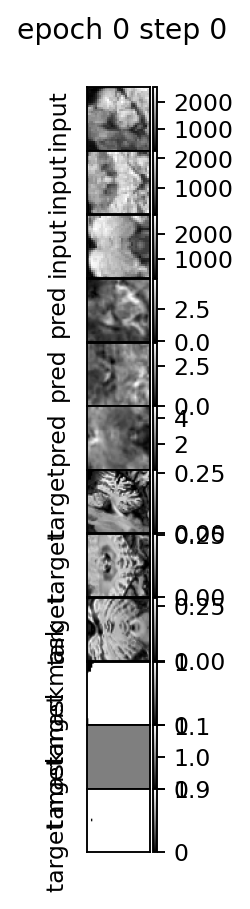

In [26]:
# Instantiate the system, may be re-used between training and testing.
model_system = INRSystem(accelerator="gpu", devices=1, precision=32)

if "in_channels" not in p.encoder:
    in_channels = int(train_dataset[0]["lr_dwi"].shape[0])
else:
    in_channels = p.encoder.in_channels

model_system.run(
    p.train.max_epochs,
    p.train.batch_size,
    in_channels=in_channels,
    pred_channels=p.decoder.out_features,
    encoder_kwargs=p.encoder.to_dict(),
    decoder_kwargs=p.decoder.to_dict(),
    train_dataset=train_dataset,
)

In [ ]:
losses = pd.read_csv(tmp_res_dir / "train_losses.csv")

plt.figure(dpi=100)
plt.plot(losses.step[50:], losses.loss[50:], label="loss")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot(losses.step[50:], losses.encoder_grad_norm[50:], label="encoder grad norm")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot(losses.step[50:], losses.decoder_grad_norm[50:], label="decoder grad norm")
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=100)
plt.plot(losses.step[500:], losses.loss[500:], label="loss")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot(losses.step[500:], losses.encoder_grad_norm[500:], label="encoder grad norm")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot(losses.step[500:], losses.decoder_grad_norm[500:], label="decoder grad norm")
plt.legend()
plt.show()

## Testing & Visualization